# Imports

In [1]:


from _dfguru import DataFrameGuru as DFG
from _occupancy_forecasting import load_data

import torch

import numpy as np
import os
dfg = DFG()
torch.cuda.empty_cache()

import ast
import pandas as pd

import matplotlib.pyplot as plt

import datetime
import json

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

from _plotting import DataPlotter


# Utility Functions & Classes

In [2]:
class StatsLogger():
    
    def __init__(self):
        self.comb_lists = []
        self.model_losses = []
        self.zero_baselines = []
        self.naive_baselines = []
        self.avg_baselines = []
        self.dataset_types = []
        self.loss_types = []
        
    def return_dataframe(self, run_id):
        return pd.DataFrame({
            "run_id": run_id,
            "dataset": self.dataset_types,
            "loss_type": self.loss_types,
            "combinations": self.comb_lists,
            "model_losses": self.model_losses,
            "zero_baselines": self.zero_baselines,
            "naive_baselines": self.naive_baselines,
            "avg_baselines": self.avg_baselines
        })
    
def handle_array_types(array_type, array, dataset, loss_type, logger):
    
    if array_type == "Combinations":
                    
        logger.dataset_types.extend(np.repeat(dataset, len(array)))
        logger.loss_types.extend(np.repeat(loss_type, len(array)))
        
        logger.comb_lists.extend(array)
        
    elif array_type == "Model Losses":
        logger.model_losses.extend(array)
        
    elif array_type == "BL zero Losses":
        logger.zero_baselines.extend(array)
        
    elif array_type == "BL naive Losses":
        logger.naive_baselines.extend(array)

    elif array_type == "BL avg Losses":
        logger.avg_baselines.extend(array)

    else:
        print(array_type, array)
        raise ValueError("array_type not recognized")
    

In [3]:
############ Inputs ############
#args = parse_arguments()
#args = prompt_for_missing_arguments(args)0
#n_run = args.n_run
#n_param = args.n_param

n_run = 10
n_param = 0

overwrite = True
################################

param_dir = "_occupancy_forecasting/parameters/wrap_up"
tb_log_dir = "_occupancy_forecasting/training_logs/wrap_up"
cp_log_dir = "_occupancy_forecasting/checkpoints/wrap_up"
path_to_data = "data/occupancy_forecasting"

frequency = "5min"
split_by = "time"


train_dict, val_dict, test_dict = load_data(
    path_to_data_dir=path_to_data, 
    frequency=frequency, 
    split_by=split_by,
    dfguru=dfg,
    with_examweek=False
)


data = train_dict[0]


In [4]:

helper_file = os.path.join("data/occupancy_forecasting", "helpers_occpred.json")
with open(helper_file, "r") as f:
    helper = json.load(f)       
norm_registered = helper["columns_to_normalize"]["registered"]
norm_temperature = helper["columns_to_normalize"]["tl"]

## Load results

In [5]:
# read txt file with training results

with open("results_wrapup_normal.txt", "r") as f:
    lines = f.readlines()
    line_str = "".join(lines)
    
    
list_of_runs = line_str.split("\n\n\n")
# remove empty strings
list_of_runs = [run for run in list_of_runs if run != ""][:-1]
list_of_runs

runs_of_interest = list_of_runs[:]

runs_of_interest

["################# Run: 0 #################\nTime: 2024-11-25 12:48:24\nDataset: train | Loss: MAE\nCombinations: [[0, 9], [0, 4], [0, 1], [0, 5], [0, 10], [0, 7], [0, 6], [0, 2], [0, 3], [0, 8], [0, 0]]\nModel Losses: [0.009174, 0.009215, 0.009297, 0.009307, 0.009342, 0.009409, 0.009479, 0.009513, 0.009543, 0.009601, 0.011038]\nBL zero Losses: [0.025558, 0.025558, 0.025558, 0.025558, 0.025558, 0.025558, 0.025558, 0.025558, 0.025558, 0.025558, 0.025558]\nBL naive Losses: [0.023304, 0.023304, 0.023304, 0.023304, 0.023304, 0.023304, 0.023304, 0.023304, 0.023304, 0.023304, 0.023304]\nBL avg Losses: [0.023492, 0.023492, 0.023492, 0.023492, 0.023492, 0.023492, 0.023492, 0.023492, 0.023492, 0.023492, 0.023492]\nHyperparameters: [('course_encoding_dim', [(np.str_('1'), np.int64(5))]), ('dataset_mode', [(np.str_('normal'), np.int64(5))]), ('dropout', [(np.str_('0'), np.int64(5))]), ('features', [(np.str_('occrate_lecture'), np.int64(1)), (np.str_('occrate_lecture_exam_cancelled_tutorium_test'

In [6]:
list_of_dfs = []
for run in runs_of_interest:
    
    splitted_run = run.split("\n")
    # filter out empty strings
    splitted_run = [elem for elem in splitted_run if elem != ""]

    run_id = int(splitted_run[0].split(" ")[2])
    if (run_id < 13) or (run_id > 16):
        continue
    
    logger = StatsLogger()
    
    for elem in splitted_run[2:]:

        by_bar = elem.split("|")
        
        if len(by_bar) == 2:
            dataset = by_bar[0].split(":")[1].strip()
            loss_type = by_bar[1].split(":")[1].strip()
 
        elif len(by_bar) == 1:
            
            if by_bar[0] == "":
                continue
            
            array_type, array = by_bar[0].split(":")
            array_type = array_type.strip()
            
            if array_type == "Hyperparameters":
                continue
            
            array = array.strip()
            array = np.array(ast.literal_eval(array))

            handle_array_types(array_type, array, dataset, loss_type, logger)
      
    run_df = logger.return_dataframe(run_id)
    
    list_of_dfs.append(run_df)
    
df_results = pd.concat(list_of_dfs).reset_index(drop=True)

In [7]:
# iterate through all combinations and load hyperparameters
import json
path_to_checkpoints = "_occupancy_forecasting/checkpoints/wrap_up"
for idx, row in df_results.iterrows():
    comb = row["combinations"]
    
    comb_path = os.path.join(path_to_checkpoints, f"run_{comb[0]}/comb_{comb[1]}")
    
    hyperparameters_path = os.path.join(comb_path, "hyperparameters.json")

    
    hyperparameters = json.load(open(hyperparameters_path, "r"))
    
    # overwrite combinations with tuple of run_id and comb_id
    df_results.at[idx, "combinations"] = (row["run_id"], comb[1])
    
    # add all hyperparameters to the dataframe
    for key, value in hyperparameters.items():
        df_results.at[idx, key] = str(value)

print(len(df_results))

df_results.head()

48


,run_id,dataset,loss_type,combinations,model_losses,zero_baselines,naive_baselines,avg_baselines,info,model_class,...,differencing,layer_norm,weight_decay,forget_gate,include_x_features,zero_sample_drop_rate,x_size,y_features_size,y_size,occcount
0,13,val,MAE,"(13, 3)",0.008218,0.018247,0.014358,0.012195,Run 13: same as 12,ed_lstm,...,none,False,0,True,True,0.1,1,0,1,False
1,13,val,MAE,"(13, 1)",0.008601,0.018247,0.014358,0.012195,Run 13: same as 12,ed_lstm,...,none,False,0,True,True,0.1,2,1,1,False
2,13,val,MAE,"(13, 2)",0.011386,0.018247,0.014358,0.012195,Run 13: same as 12,ed_lstm,...,none,False,0,True,True,0.1,2,1,1,False
3,13,val,MAE,"(13, 0)",0.015010,0.018247,0.014358,0.012195,Run 13: same as 12,ed_lstm,...,none,False,0,True,True,0.1,1,0,1,False
4,13,val,R2,"(13, 3)",0.569246,-0.441705,-2.803663,0.123909,Run 13: same as 12,ed_lstm,...,none,False,0,True,True,0.1,1,0,1,False


In [8]:

def filter_dataframe_by_column_value(df, column, value):
    return df[df[column] == value].reset_index(drop=True)



def filter_dataframe_by_dict(df, dict_filter):
    for key, value in dict_filter.items():
        df = filter_dataframe_by_column_value(df, key, value)
    return df


df_results = filter_dataframe_by_dict(
    df_results,
    {
        "loss_type": "MAE",
        #"dataset": "test"
        #"frequency": "15min",
        #"lr": "0.001",
        #"batch_size": "32",
       # "with_examweek": "False",
        #"course_encoding_dim": "3",
        #"room_ids": "[0]",
        #"num_layers": "3",
        #"hidden_size": "[32, 32]",
        #"y_horizon": "36",
        #"dataset": "test"
    }
)


df_results

,run_id,dataset,loss_type,combinations,model_losses,zero_baselines,naive_baselines,avg_baselines,info,model_class,...,differencing,layer_norm,weight_decay,forget_gate,include_x_features,zero_sample_drop_rate,x_size,y_features_size,y_size,occcount
0,13,val,MAE,"(13, 3)",0.008218,0.018247,0.014358,0.012195,Run 13: same as 12,ed_lstm,...,none,False,0,True,True,0.1,1,0,1,False
1,13,val,MAE,"(13, 1)",0.008601,0.018247,0.014358,0.012195,Run 13: same as 12,ed_lstm,...,none,False,0,True,True,0.1,2,1,1,False
2,13,val,MAE,"(13, 2)",0.011386,0.018247,0.014358,0.012195,Run 13: same as 12,ed_lstm,...,none,False,0,True,True,0.1,2,1,1,False
3,13,val,MAE,"(13, 0)",0.015010,0.018247,0.014358,0.012195,Run 13: same as 12,ed_lstm,...,none,False,0,True,True,0.1,1,0,1,False
4,13,test,MAE,"(13, 1)",0.016267,0.026335,0.022605,0.020618,Run 13: same as 12,ed_lstm,...,none,False,0,True,True,0.1,2,1,1,False
5,13,test,MAE,"(13, 3)",0.016713,0.026335,0.022605,0.020618,Run 13: same as 12,ed_lstm,...,none,False,0,True,True,0.1,1,0,1,False
6,13,test,MAE,"(13, 2)",0.019070,0.026335,0.022605,0.020618,Run 13: same as 12,ed_lstm,...,none,False,0,True,True,0.1,2,1,1,False
7,13,test,MAE,"(13, 0)",0.020217,0.026335,0.022605,0.020618,Run 13: same as 12,ed_lstm,...,none,False,0,True,True,0.1,1,0,1,False
8,14,val,MAE,"(14, 1)",0.008040,0.018247,0.014358,0.012195,Run 14: same as 13,ed_lstm,...,none,False,0,True,True,0.1,2,1,1,False
9,14,val,MAE,"(14, 3)",0.008247,0.018247,0.014358,0.012195,Run 14: same as 13,ed_lstm,...,none,False,0,True,True,0.1,1,0,1,False


In [9]:
# keep onyl necessary columns
df_results = df_results[["dataset", "features", "run_id", "model_losses"]]
df_results

,dataset,features,run_id,model_losses
0,val,occrate_coursenumber,13,0.008218
1,val,occrate_avgocc_coursenumber,13,0.008601
2,val,occrate_avgocc,13,0.011386
3,val,occrate,13,0.015010
4,test,occrate_avgocc_coursenumber,13,0.016267
5,test,occrate_coursenumber,13,0.016713
6,test,occrate_avgocc,13,0.019070
7,test,occrate,13,0.020217
8,val,occrate_avgocc_coursenumber,14,0.008040
9,val,occrate_coursenumber,14,0.008247


### Try to create table with test and val loss for every combination !

In [10]:
# combine all runs with the same dataset and features
df_losses = df_results.pivot(index=['features', 'run_id'], columns='dataset', values='model_losses').reset_index()
df_losses.columns = ['features', 'run_id', 'test_loss', 'val_loss']

df_losses


,features,run_id,test_loss,val_loss
0,occrate,13,0.020217,0.015010
1,occrate,14,0.020431,0.015677
2,occrate,15,0.020667,0.015186
3,occrate_avgocc,13,0.019070,0.011386
4,occrate_avgocc,14,0.018379,0.011360
5,occrate_avgocc,15,0.018512,0.010919
6,occrate_avgocc_coursenumber,13,0.016267,0.008601
7,occrate_avgocc_coursenumber,14,0.016066,0.008040
8,occrate_avgocc_coursenumber,15,0.016479,0.008257
9,occrate_coursenumber,13,0.016713,0.008218


### Suggestion:

In [11]:
df = df_losses.copy(deep=True)

In [12]:
# Group data by feature combination
df_grouped = df.groupby('features').agg(
    mean_validation_mae=('val_loss', 'mean'),
    std_validation_mae=('val_loss', 'std'),
    mean_test_mae=('test_loss', 'mean'),
    std_test_mae=('test_loss', 'std')
).reset_index()


# to avoid clutter
df_grouped

,features,mean_validation_mae,std_validation_mae,mean_test_mae,std_test_mae
0,occrate,0.015291,0.000346,0.020438,0.000225
1,occrate_avgocc,0.011222,0.000262,0.018654,0.000367
2,occrate_avgocc_coursenumber,0.008299,0.000283,0.016271,0.000207
3,occrate_coursenumber,0.008358,0.000217,0.016613,0.000415


In [13]:
# Expand features into individual columns
all_features = set.union(*df['features'].apply(lambda x: set(x.split(','))))
for feature in all_features:
    df[feature] = df['features'].apply(lambda x: feature in x)

# Group by individual features and calculate mean/std
feature_analysis = {}
for feature in all_features:
    feature_analysis[feature] = {
        'mean_validation_mae': df.loc[df[feature], 'val_loss'].mean(),
        'std_validation_mae': df.loc[df[feature], 'val_loss'].std(),
        'mean_test_mae': df.loc[df[feature], 'test_loss'].mean(),
        'std_test_mae': df.loc[df[feature], 'test_loss'].std()
    }

df_features_and_combs = pd.DataFrame.from_dict(feature_analysis, orient='index')
df_features_and_combs.sort_values(["mean_test_mae", "std_test_mae" ,"mean_validation_mae", "std_validation_mae"])

,mean_validation_mae,std_validation_mae,mean_test_mae,std_test_mae
occrate_avgocc_coursenumber,0.008299,0.000283,0.016271,0.000207
occrate_coursenumber,0.008358,0.000217,0.016613,0.000415
occrate_avgocc,0.009761,0.001619,0.017462,0.001332
occrate,0.010792,0.002990,0.017994,0.001775


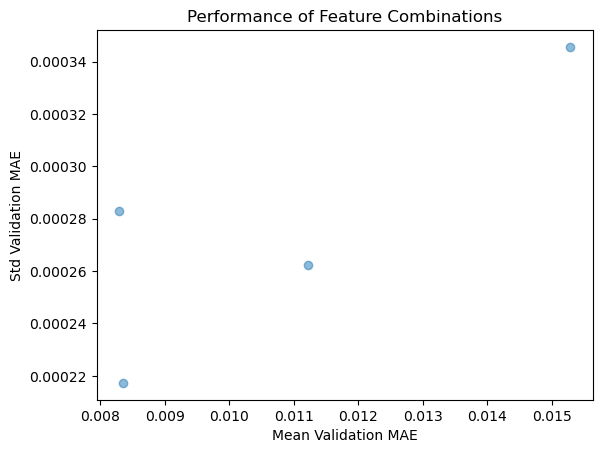

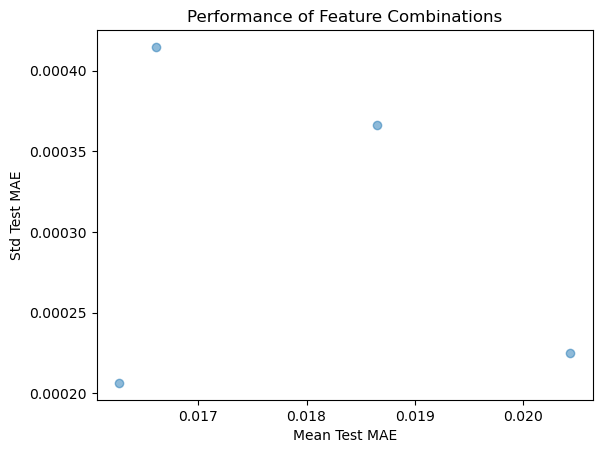

In [14]:

# scatter plot of mean and std of validation MAE
plt.scatter(df_grouped['mean_validation_mae'], df_grouped['std_validation_mae'], alpha=0.5)
plt.xlabel('Mean Validation MAE')
plt.ylabel('Std Validation MAE')
plt.title('Performance of Feature Combinations')
plt.show()

plt.scatter(df_grouped['mean_test_mae'], df_grouped['std_test_mae'], alpha=0.5)
plt.xlabel('Mean Test MAE')
plt.ylabel('Std Test MAE')
plt.title('Performance of Feature Combinations')
plt.show()

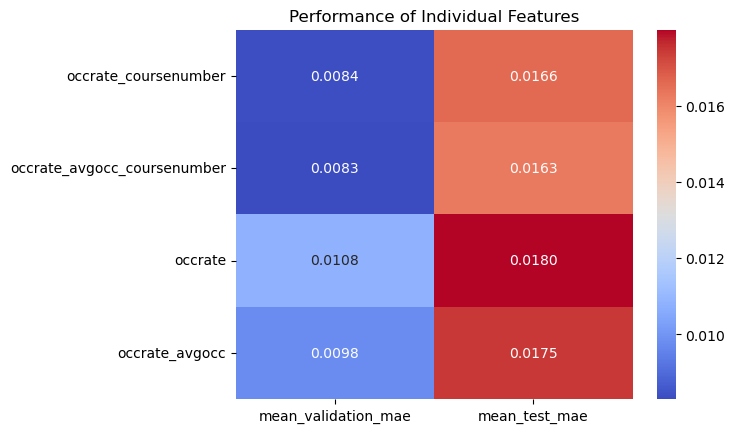

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert feature analysis to a DataFrame if not already
heatmap_data = df_features_and_combs[['mean_validation_mae', 'mean_test_mae']]
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="coolwarm")
plt.title("Performance of Individual Features")
plt.show()


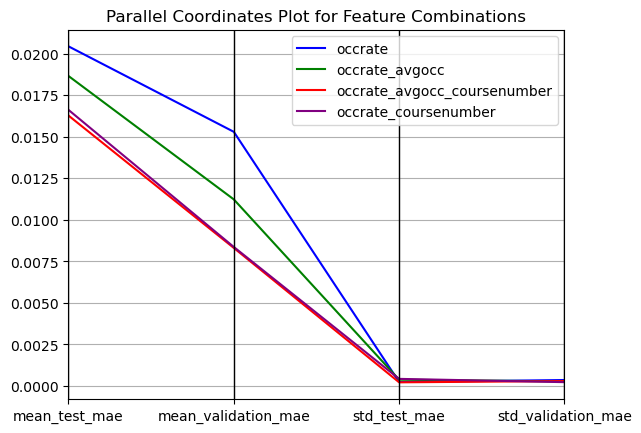

In [16]:
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

top_combinations = df_grouped.nsmallest(100, 'mean_test_mae')  # Top 100 combinations
parallel_data = top_combinations.melt(id_vars='features', value_vars=['mean_validation_mae', 'std_validation_mae', 'mean_test_mae', 'std_test_mae'])

# Pivot the melted data back to wide format
wide_data = parallel_data.pivot(index='features', columns='variable', values='value').reset_index()

# Plot parallel coordinates
parallel_coordinates(wide_data, 'features', color=['blue', 'green', 'red', 'purple'])
plt.title("Parallel Coordinates Plot for Feature Combinations")
plt.show()

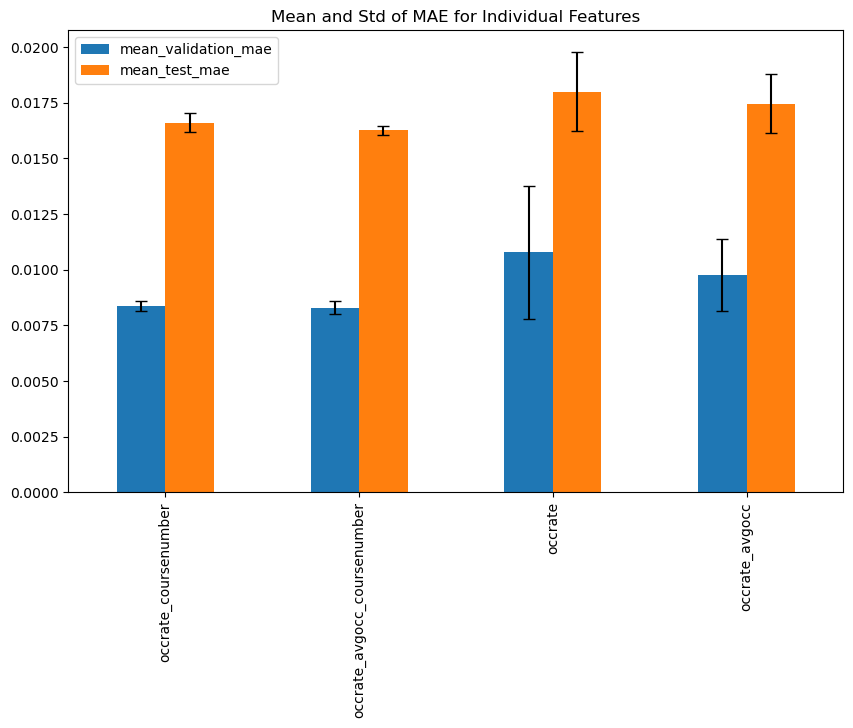

In [17]:
df_features_and_combs[['mean_validation_mae', 'mean_test_mae']].plot.bar(
    yerr=df_features_and_combs[['std_validation_mae', 'std_test_mae']].values.T,
    figsize=(10, 6),
    capsize=4,
    title="Mean and Std of MAE for Individual Features"
)
plt.show()


In [18]:
# Step 1: Aggregate df by features to match feature_analysis_df
aggregated_df = df.groupby('features')[['test_loss', 'val_loss']].mean().reset_index()

# Step 2: Ensure binary_features matches feature_analysis_df
binary_features = df['features'].str.get_dummies(sep='_')
binary_features = binary_features.groupby(df['features']).first()  # One row per feature combination


# Step 3: Align binary_features with feature_analysis_df
binary_features = binary_features.loc[feature_analysis_df.index]  # Ensure same order as feature_analysis_df

# Step 4: Compute correlations
target_metrics = df_features_and_combs[['mean_validation_mae', 'mean_test_mae']].mean(axis=1)
correlations = binary_features.corrwith(target_metrics)

print(binary_features)
print(target_metrics)
print(correlations)
## Step 5: Visualize the results
#import matplotlib.pyplot as plt

#correlations.sort_values(ascending=True).plot.barh(figsize=(10, 6))
#plt.title("Correlation of Feature Inclusion with Mean MAE")
#plt.xlabel("Correlation")
#plt.show()


#correlations.sort_values(ascending=True).plot.barh(figsize=(10, 6))
#plt.title("Correlation of Feature Inclusion with Mean MAE")
#plt.xlabel("Correlation")
#plt.show()

NameError: name 'feature_analysis_df' is not defined

### Explanation of Correlation

Why `occrate` is NaN

====================

- The `occrate` column in `binary_features` is constant (all 1s):

  occrate

  1

  1

  1

  1



- A constant feature has zero variance (σ_X = 0).

- In Pearson's correlation formula:

  r = Cov(X, Y) / (σ_X ⋅ σ_Y)

  The denominator (σ_X) becomes zero, and the correlation cannot be computed, resulting in `NaN`.



Calculation for `avgocc`

=========================

We calculate the correlation for `avgocc` as an example.



Values:

-------

- X = [0, 1, 1, 0] (from `binary_features['avgocc']`)

- Y = [0.012485, 0.012285, 0.013611, 0.014393] (from `target_metrics`)



Step 1: Compute Means

---------------------

X̄ = (0 + 1 + 1 + 0) / 4 = 0.5

Ȳ = (0.012485 + 0.012285 + 0.013611 + 0.014393) / 4 = 0.013194



Step 2: Compute Deviations

--------------------------

X_i - X̄ = [-0.5, 0.5, 0.5, -0.5]

Y_i - Ȳ = [0.012485 - 0.013194, 0.012285 - 0.013194, 0.013611 - 0.013194, 0.014393 - 0.013194]

        = [-0.000709, -0.000909, 0.000417, 0.001199]



Step 3: Compute Covariance

--------------------------

Cov(X, Y) = Σ (X_i - X̄)(Y_i - Ȳ)

          = (-0.5)(-0.000709) + (0.5)(-0.000909) + (0.5)(0.000417) + (-0.5)(0.001199)

          = 0.000354 - 0.000455 + 0.000208 - 0.000599 = -0.000492



Step 4: Compute Variances

-------------------------

σ_X² = Σ (X_i - X̄)² = (-0.5)² + (0.5)² + (0.5)² + (-0.5)² = 1.0

σ_Y² = Σ (Y_i - Ȳ)²

      = (-0.000709)² + (-0.000909)² + (0.000417)² + (0.001199)²

      = 0.000000503 + 0.000000826 + 0.000000174 + 0.000001438 = 0.000002941



σ_X = √1.0 = 1.0

σ_Y = √0.000002941 = 0.001715



Step 5: Compute Correlation

---------------------------

r = Cov(X, Y) / (σ_X ⋅ σ_Y)

r = -0.000492 / (1.0 ⋅ 0.001715) = -0.286


# Impact of one Feature

Measuring the impact of a single feature, even when it appears in combination with others, can be approached by isolating its contribution to the model's performance. Here’s a systematic way to assess the impact of individual features:

Approach 1: Marginal Contribution (Shapley Value Inspired)

    Baseline Performance: Compute the average performance (e.g., mean validation MAE) for all combinations without the feature.
    With Feature Performance: Compute the average performance for all combinations with the feature.
    Impact: Measure the difference in average performance:
    Impact=Mean(MAE without feature)−Mean(MAE with feature)
    Impact=Mean(MAE without feature)−Mean(MAE with feature)
        A positive impact indicates the feature improves performance.
        A negative impact indicates the feature worsens performance.

In [ ]:
def calc_marginal_contribution(dataframe, feature, target):
    with_feature = dataframe[dataframe['features'].str.contains(feature)]
    without_feature = dataframe[~dataframe['features'].str.contains(feature)]
    return with_feature[target].mean() - without_feature[target].mean()
    
feature = "coursenumber"
target = "mean_test_mae"
impact = calc_marginal_contribution(df_grouped, feature, target)
print(f"Impact of {feature}: {impact:.4f}")


Impact of coursenumber: -0.0031


Approach 2: Statistical Comparison

## Check statistics slides!! must it be standard normal?

# We need larger smaple check servers!!

Perform a statistical test to compare the performance of combinations with and without the feature:

    Null Hypothesis: The feature does not improve performance (mean performance is the same with or without it).
    Use a t-test or Mann-Whitney U test to compare performance distributions.

In [ ]:
from scipy.stats import ttest_ind

dataframe = df_grouped
feature = "coursenumber"
target = "mean_test_mae"

with_feature = dataframe[dataframe['features'].str.contains(feature)]
without_feature = dataframe[~dataframe['features'].str.contains(feature)]

# Extract performance distributions
with_performance = with_feature[target]
without_performance = without_feature[target]

# Perform t-test
print(df_grouped)
t_stat, p_value = ttest_ind(with_performance, without_performance, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")


                      features  mean_validation_mae  std_validation_mae  \
0                      occrate             0.015291            0.000346   
1               occrate_avgocc             0.011222            0.000262   
2  occrate_avgocc_coursenumber             0.008299            0.000283   
3         occrate_coursenumber             0.008358            0.000217   

   mean_test_mae  std_test_mae  
0       0.020438      0.000225  
1       0.018654      0.000367  
2       0.016271      0.000207  
3       0.016613      0.000415  
T-statistic: -3.4167, P-value: 0.1676


In [ ]:
# Try mann-whitney u test
from scipy.stats import mannwhitneyu

# Separate groups by "coursenumber"
group_true = df[df['coursenumber']]['mean_validation_mae']
group_false = df[~df['coursenumber']]['mean_validation_mae']

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(group_true, group_false, alternative='two-sided')
print(f"Mann-Whitney U Test: U-statistic = {stat}, P-value = {p_value}")


Approach 3: Feature Inclusion Analysis

Analyze how the inclusion of a feature affects performance within combinations:

    Group by feature combinations.
    Compare the mean performance for combinations with and without the feature controlling for other features.

In [ ]:
# Create a binary column for feature inclusion
def calc_feature_inclusion_effect(dataframe, feature, target):
    dataframe[feature] = dataframe['features'].apply(lambda x: feature in x.split('_'))
    feature_inclusion = dataframe.groupby(feature)[target].agg(['mean', 'std']).reset_index()
    return feature_inclusion

dataframe = df
target = "test_loss"
feature_inclusion = calc_feature_inclusion_effect(dataframe, feature, target)
print(feature_inclusion)


   coursenumber      mean       std
0         False  0.019546  0.001015
1          True  0.016442  0.000348


Approach 4: Interaction Effects

Model interaction effects using a simple regression model:

    Encode feature combinations as binary variables (one-hot encoding for presence/absence of each feature).
    Fit a linear regression where the dependent variable is the mean_validation_mae, and independent variables are binary indicators for each feature.
    Coefficients of the regression indicate the individual contribution of each feature, controlling for others.

In [20]:
from sklearn.linear_model import LinearRegression

def get_binary_features(dataframe):
    binary_features = dataframe['features'].str.get_dummies(sep='_')
    #binary_features = binary_features.groupby(dataframe['features']).first()
    return binary_features

def calc_regression_feature_impact(dataframe, target):
    
    binary_features = get_binary_features(dataframe)
    X = binary_features
    y = dataframe[target]
    
    model = LinearRegression().fit(X, y)

    reg_results = pd.Series(np.append(model.coef_, model.intercept_), index=list(X.columns) + ['intercept'])
    
    return reg_results, model
    

In [21]:

reg_results, model = calc_regression_feature_impact(df, 'test_loss')
print(reg_results)



avgocc         -0.001063
coursenumber   -0.003104
occrate         0.000000
intercept       0.020078
dtype: float64


Approach 5: SHAP Values (Model-Agnostic Explanation)

Train a surrogate model (e.g., decision tree or random forest) on the feature-performance data and use SHAP (SHapley Additive exPlanations) to measure each feature's contribution to the performance metric.

Steps:

    Train a surrogate model to predict mean_validation_mae based on feature combinations.
    Use SHAP to decompose predictions into feature contributions.

In [22]:
# research what shapley score is!

# try decision tree!

binary_features

,avgocc,coursenumber,occrate
features,,,
occrate,0,0,1
occrate_avgocc,1,0,1
occrate_avgocc_coursenumber,1,1,1
occrate_coursenumber,0,1,1


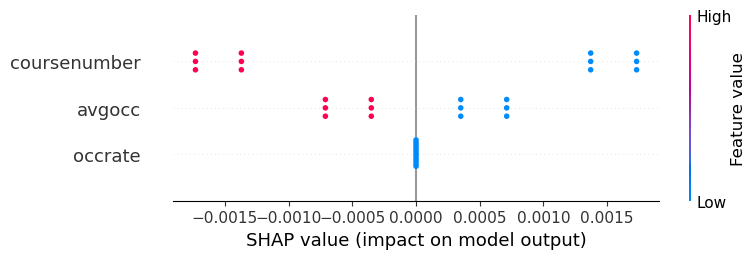

In [28]:
# Create DataFrame

#def calc_regression_feature_impact(dataframe, target):
    
#    binary_features = get_binary_features(dataframe)
#    X = binary_features
#    y = dataframe[target]
    
#    model = LinearRegression().fit(X, y)

#    reg_results = pd.Series(np.append(model.coef_, model.intercept_), index=list(X.columns) + ['intercept'])
    
#    return reg_results, model

import shap
from sklearn.tree import DecisionTreeRegressor


dataframe = df
X = get_binary_features(dataframe)
y = dataframe["test_loss"]


# Fit a Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X, y)

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(model)

shap_set = X
shap_values = explainer(shap_set)

# Summary plot for SHAP values
shap.summary_plot(shap_values, shap_set)

# Kinda old!

In [18]:
# fill dataframe with group means and stds



group_list = []

for group, df in results_out.groupby(["features"]):
    print(group)
    print(df["model_losses"].mean())
    print(df["model_losses"].std())
    print()
    # add data to new dataframe
    
    group_list.append(
        (group[0], df["model_losses"].mean(), df["model_losses"].std())
    )
    
df_plot = pd.DataFrame(group_list, columns=["features", "mean", "std"])



('occrate',)
0.020438333333333336
0.0002250896117845821

('occrate_avgocc',)
0.018653666666666666
0.0003666365139117126

('occrate_avgocc_coursenumber',)
0.016270666666666666
0.00020652441340755182

('occrate_coursenumber',)
0.016612666666666668
0.0004147051161166604



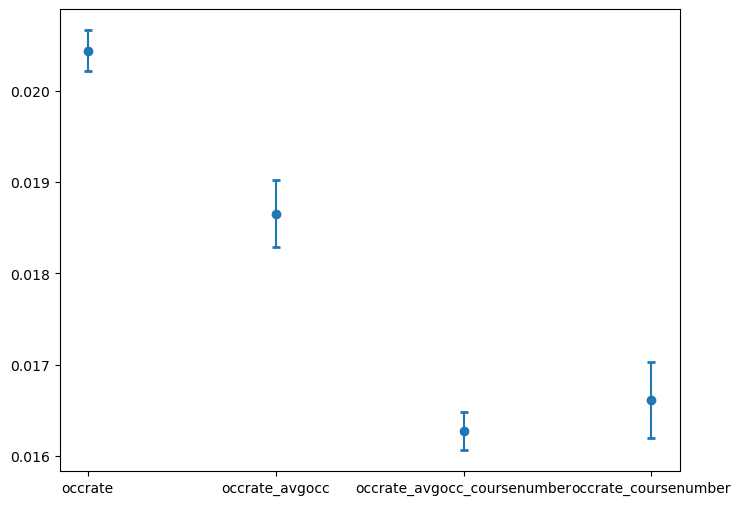

In [19]:
import matplotlib.pyplot as plt

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))

# Plot mean with error bars (standard deviation)
ax.errorbar(
    df_plot["features"],
    df_plot["mean"],
    yerr=df_plot["std"],
    fmt="o",
    capsize=3,
    capthick=2,
    label="Mean MAE with Std Dev",
)

plt.show()

In [58]:
def advanced_grouping_function(features):
    if "coursenumber" in features:
        return "yes"
    else:
        return "no"
    
    

In [63]:
def advanced_grouping_function(features):
    if "coursenumber" in features:
        return "yes"
    else:
        return "no"
group_by_avgocc = results_out.groupby(results_out["features"].apply(advanced_grouping_function))
group_by_avgocc["model_losses"].mean()


features
no     0.019546
yes    0.016442
Name: model_losses, dtype: float64

In [64]:
def advanced_grouping_function(features):
    if "avgocc" in features:
        return "yes"
    else:
        return "no"
    
group_by_avgocc = results_out.groupby(results_out["features"].apply(advanced_grouping_function))
group_by_avgocc["model_losses"].mean()

features
no     0.018526
yes    0.017462
Name: model_losses, dtype: float64

In [ ]:
pretty_results = results_out[["features", "model_losses", "avg_baselines", "naive_baselines", "zero_baselines"]]

# split features by "_"
pretty_results["features"] = pretty_results["features"].apply(lambda x: x.split("_"))

# do not cut off columns
pd.set_option('display.max_colwidth', None)
pretty_results.reset_index(drop=True, inplace=True)



In [ ]:
#pretty_results.to_csv("pretty_results.csv", index=False)

## Old Code

In [ ]:
import ast
import pandas as pd

list_of_dfs = []
for run in runs_of_interest:
    
    splitted_run = run.split("\n")
    # filter out empty strings
    splitted_run = [elem for elem in splitted_run if elem != ""]

    run_id = int(splitted_run[0].split(" ")[2])
    if (run_id < 13) or (run_id > 15):
        continue
    
    
    comb_lists = []
    model_losses = []
    zero_baselines = []
    naive_baselines = []
    avg_baselines = []
    dataset_types = []
    loss_types = []
    
    for elem in splitted_run[2:]:

        by_bar = elem.split("|")
        
        if len(by_bar) == 2:
            dataset = by_bar[0].split(":")[1].strip()
            loss_type = by_bar[1].split(":")[1].strip()
 
        elif len(by_bar) == 1:
            
            if by_bar[0] == "":
                continue
            
            array_type, array = by_bar[0].split(":")
            array_type = array_type.strip()
            
            if array_type == "Hyperparameters":
                continue
            
            array = array.strip()
            array = np.array(ast.literal_eval(array))

            
            if array_type == "Combinations":
                            
                dataset_types.extend(np.repeat(dataset, len(array)))
                loss_types.extend(np.repeat(loss_type, len(array)))
                
                comb_lists.extend(array)
                
            elif array_type == "Model Losses":
                model_losses.extend(array)
                
            elif array_type == "BL zero Losses":
                zero_baselines.extend(array)
                
            elif array_type == "BL naive Losses":
                naive_baselines.extend(array)

            elif array_type == "BL avg Losses":
                avg_baselines.extend(array)

            else:
                print(array_type, array)
                raise
      
    run_df = pd.DataFrame({
        "run_id": run_id,
        "dataset": dataset_types,
        "loss_type": loss_types,
        "combinations": comb_lists,
        "model_losses": model_losses,
        "zero_baselines": zero_baselines,
        "naive_baselines": naive_baselines,
        "avg_baselines": avg_baselines
    })
    
    list_of_dfs.append(run_df)
    
results_df = pd.concat(list_of_dfs).reset_index(drop=True)
results_df

In [ ]:
## loss type = MAE
#results_filt = filter_dataframe_by_column_value(results_df, "loss_type", "MAE")
## model class = ed_lstm
#results_filt = filter_dataframe_by_column_value(results_filt, "model_class", "ed_lstm")
## split_by = time
#results_filt = filter_dataframe_by_column_value(results_filt, "split_by", "time")
## frequency = 5min
#results_filt = filter_dataframe_by_column_value(results_filt, "frequency", "15min")
## lr = 0.001
#results_filt = filter_dataframe_by_column_value(results_filt, "lr", "0.001")
## batch_size = "32"
#results_filt = filter_dataframe_by_column_value(results_filt, "batch_size", "32")
## with_examweek = False
#results_filt = filter_dataframe_by_column_value(results_filt, "with_examweek", "False")
## course_encoding_dim = 3
#results_filt = filter_dataframe_by_column_value(results_filt, "course_encoding_dim", "3")
## room_id = 0
#results_filt = filter_dataframe_by_column_value(results_filt, "room_ids", "[0]")


## num_layers = 3
#results_filt = filter_dataframe_by_column_value(results_filt, "num_layers", "3")

## hidden_size = "[32, 32]"
#results_filt = filter_dataframe_by_column_value(results_filt, "hidden_size", "[32, 32]")

### x_horizon = 36
#results_filt = filter_dataframe_by_column_value(results_filt, "y_horizon", "36")

In [5]:
# 2024-04-09 07:00:00
start = datetime.datetime(2024, 4, 16, 7, 0, 0)
# 2024-04-09 21:00:00
stop = datetime.datetime(2024, 4, 16, 21, 0, 0)

plot_data = dfg.filter_by_timestamp(data, "datetime", start, stop) 

plot_data["tl"] = (plot_data["tl"] - norm_temperature["min"]) / (norm_temperature["max"] - norm_temperature["min"])
plot_data["registered"] = (plot_data["registered"] - norm_registered["min"]) / (norm_registered["max"] - norm_registered["min"])

plotter = DataPlotter(
    save_path="",
    dataframe_guru=dfg
)

#plotter.plot_some_features(plot_data)


### Features that make sense

In [8]:
train_dict[0].columns

Index(['datetime', 'avgocc', 'occrate', 'occcount', 'occcountdiff',
       'occratediff', 'studyarea', 'registered', 'maxocccount', 'ects',
       'maxoccrate', 'lecturerampbefore', 'lecture', 'type',
       'maxoccrateestimate', 'lecturerampafter', 'coursenumber', 'cancelled',
       'exam', 'test', 'offsite', 'tutorium', 'level', 'maxocccountestimate',
       'VL', 'UE', 'KS', 'Informatik', 'None_sa', 'Volkswirtschaftslehre',
       'Chemie', 'Wirtschaftsinformatik', 'Maschinenbau',
       'Betriebswirtschaftslehre', 'Rechtswissenschaften', 'Mathematik',
       'Mechatronik', 'Informationselektronik', 'Biologische Chemie',
       'Sozialwissenschaften', 'Artificial Intelligence', 'Kunststofftechnik',
       'Statistik', 'Pädagogik', 'Medical Engineering',
       'B1 - Bachelor 1. Jahr', 'None_level', 'B2 - Bachelor 2. Jahr',
       'M1 - Master 1. Jahr', 'B3 - Bachelor 3. Jahr', 'D - Diplom',
       'M2 - Master 2. Jahr', 'hod1', 'hod2', 'dow1', 'dow2', 'week1', 'week2',
       'holi

In [9]:
course_features = {"maxocccount", "maxoccrate" ,"maxoccrateestimate", "maxocccountestimate",
                "coursenumber", "exam",  "test", "tutorium", "cancelled","offsite", 
                "lecture", "lecturerampbefore", "lecturerampafter",
                "registered", "type", "studyarea", "ects", "level"}
datetime_features = {"dow", "hod", "week", "holiday", "zwickltag"}
general_features = {"occcount", "occrate", "avgocc"}
weather_features = {"weather"}
shift_features = {"occcount1week", "occrate1week", "occcount1day", "occrate1day"}

In [10]:
train_dict[0].columns

Index(['datetime', 'avgocc', 'occrate', 'occcount', 'occcountdiff',
       'occratediff', 'studyarea', 'registered', 'maxocccount', 'ects',
       'maxoccrate', 'lecturerampbefore', 'lecture', 'type',
       'maxoccrateestimate', 'lecturerampafter', 'coursenumber', 'cancelled',
       'exam', 'test', 'offsite', 'tutorium', 'level', 'maxocccountestimate',
       'VL', 'UE', 'KS', 'Informatik', 'None_sa', 'Volkswirtschaftslehre',
       'Chemie', 'Wirtschaftsinformatik', 'Maschinenbau',
       'Betriebswirtschaftslehre', 'Rechtswissenschaften', 'Mathematik',
       'Mechatronik', 'Informationselektronik', 'Biologische Chemie',
       'Sozialwissenschaften', 'Artificial Intelligence', 'Kunststofftechnik',
       'Statistik', 'Pädagogik', 'Medical Engineering',
       'B1 - Bachelor 1. Jahr', 'None_level', 'B2 - Bachelor 2. Jahr',
       'M1 - Master 1. Jahr', 'B3 - Bachelor 3. Jahr', 'D - Diplom',
       'M2 - Master 2. Jahr', 'hod1', 'hod2', 'dow1', 'dow2', 'week1', 'week2',
       'holi

#### Features Columns

Essential Features:
* Occupancy information: number of occupancts absolute or relative (divided by room capacity)
* Time stamp: Temporal resolution of t minutes

Course Features:
* Lecture: If a lecture takes place or not
* Date Specific Features: Exam, Test, Tutorium, Cancelled
* Course Specific Features: Registered students, Type (VL,UE,KS), Study area, Level, Course number

Time-related Features:
* Time, Weekday, (Calendarweek)
* Holiday, Zwickltag

Weather Features:
* Temperature, Air pressure, Precipation (sum over time interval), Wind speed, Air humidity, Sunshine duration

Additional Features:
* Average occupancy information of last k weeks

'VL', 'UE', 'KS', 

Study area: Maybe try with learnable parameter
'Informatik', 'None_sa',
'Volkswirtschaftslehre', 'Chemie', 'Wirtschaftsinformatik',
'Maschinenbau', 'Betriebswirtschaftslehre', 'Rechtswissenschaften',
'Mathematik', 'Mechatronik', 'Informationselektronik',
'Biologische Chemie', 'Sozialwissenschaften', 'Artificial Intelligence',
'Kunststofftechnik', 'Statistik', 'Pädagogik', 'Medical Engineering',

Level: Maybe try with learnable parameter
'B1 - Bachelor 1. Jahr', 'None_level', 'B2 - Bachelor 2. Jahr',
'M1 - Master 1. Jahr', 'B3 - Bachelor 3. Jahr', 'D - Diplom',
'M2 - Master 2. Jahr', 

In [11]:
# General Columns
# datetime, occupancy information (occcount, occrate=occcount/room_capacity)
# lecture ?

"lecture"
# Columns Concerning Specific Course Dates
# ["lecture", "exam", "test", "tutorium", "cancelled"]
# Course Specific Columns
# ["coursenumber", "type", "studyarea", "ects", "level"]

'lecture'

## Generate Feature Combinations

In [12]:
# add always
["occrate"]

# add once 
["lecture"]

# lecture
["lecture"]

# Columns Concerning Specific Course Dates
["exam", "test", "tutorium", "cancelled"]

# Course Specific Features: Registered students, Type (VL,UE,KS), Study area, Level, Course number
["registered", "type", "studyarea", "level", "coursenumber"]

# Time Related
["dow", "hod"]

# Weather, in first phase add all weather variables
["weather"]

# additional
["avgocc"]

['avgocc']

In [74]:
#all_features = ["exam"] +  ["tutorium_test_cancelled"] + ["registered", "type", "studyarea", "coursenumber"] + ["dow", "hod"]

results_out.features.unique()

array(['occrate_avgocc_coursenumber', 'occrate_coursenumber',
       'occrate_avgocc', 'occrate'], dtype=object)

In [1]:
all_features = ["avgocc", "coursenumber", "exam", "weather", "dow", "hod", "tutorium_test_cancelled", "type", "registered", "lecture", "studyarea"]
all_features

['avgocc',
 'coursenumber',
 'exam',
 'weather',
 'dow',
 'hod',
 'tutorium_test_cancelled',
 'type',
 'registered',
 'lecture',
 'studyarea']

In [2]:
# get all 14*14 combinations of features
import itertools
all_combinations = []
for i in range(1, len(all_features)+1):
    
    combs = ["_".join(list(x)) for x in itertools.combinations(all_features, i)]
    all_combinations.extend(combs)

# add occrate to all combinations
all_combinations = ["occrate_" + comb for comb in all_combinations]
all_combinations.append("occrate")


print(len(all_combinations))
# save list as json file
import json
with open("all_combinations.json", "w") as f:
    json.dump(all_combinations, f)

all_combinations

2048


['occrate_avgocc',
 'occrate_coursenumber',
 'occrate_exam',
 'occrate_weather',
 'occrate_dow',
 'occrate_hod',
 'occrate_tutorium_test_cancelled',
 'occrate_type',
 'occrate_registered',
 'occrate_lecture',
 'occrate_studyarea',
 'occrate_avgocc_coursenumber',
 'occrate_avgocc_exam',
 'occrate_avgocc_weather',
 'occrate_avgocc_dow',
 'occrate_avgocc_hod',
 'occrate_avgocc_tutorium_test_cancelled',
 'occrate_avgocc_type',
 'occrate_avgocc_registered',
 'occrate_avgocc_lecture',
 'occrate_avgocc_studyarea',
 'occrate_coursenumber_exam',
 'occrate_coursenumber_weather',
 'occrate_coursenumber_dow',
 'occrate_coursenumber_hod',
 'occrate_coursenumber_tutorium_test_cancelled',
 'occrate_coursenumber_type',
 'occrate_coursenumber_registered',
 'occrate_coursenumber_lecture',
 'occrate_coursenumber_studyarea',
 'occrate_exam_weather',
 'occrate_exam_dow',
 'occrate_exam_hod',
 'occrate_exam_tutorium_test_cancelled',
 'occrate_exam_type',
 'occrate_exam_registered',
 'occrate_exam_lecture',


### Read out results files

In [15]:
# read txt file with training results

with open("results_wrapup_normal.txt", "r") as f:
    lines = f.readlines()
    line_str = "".join(lines)
    
    
list_of_runs = line_str.split("\n\n\n")
# remove empty strings
list_of_runs = [run for run in list_of_runs if run != ""][:-1]
list_of_runs

runs_of_interest = list_of_runs[:]

runs_of_interest

In [18]:
import ast
import pandas as pd

list_of_dfs = []
for run in runs_of_interest:
    
    splitted_run = run.split("\n")
    # filter out empty strings
    splitted_run = [elem for elem in splitted_run if elem != ""]

    run_id = int(splitted_run[0].split(" ")[2])
    if (run_id < 0) or (run_id > 15):
        continue
    
    
    comb_lists = []
    model_losses = []
    zero_baselines = []
    naive_baselines = []
    avg_baselines = []
    dataset_types = []
    loss_types = []
    
    for elem in splitted_run[2:]:

        by_bar = elem.split("|")
        
        if len(by_bar) == 2:
            dataset = by_bar[0].split(":")[1].strip()
            loss_type = by_bar[1].split(":")[1].strip()

            
        elif len(by_bar) == 1:
            
            if by_bar[0] == "":
                continue
            
            array_type, array = by_bar[0].split(":")
            array_type = array_type.strip()
            
            if array_type == "Hyperparameters":
                continue
            
            array = array.strip()
            array = np.array(ast.literal_eval(array))

            
            if array_type == "Combinations":
                            
                dataset_types.extend(np.repeat(dataset, len(array)))
                loss_types.extend(np.repeat(loss_type, len(array)))
                
                comb_lists.extend(array)
                
            elif array_type == "Model Losses":
                model_losses.extend(array)
                
            elif array_type == "BL zero Losses":
                zero_baselines.extend(array)
                
            elif array_type == "BL naive Losses":
                naive_baselines.extend(array)

            elif array_type == "BL avg Losses":
                avg_baselines.extend(array)

            else:
                print(array_type, array)
                raise
      
    run_df = pd.DataFrame({
        "run_id": run_id,
        "dataset": dataset_types,
        "loss_type": loss_types,
        "combinations": comb_lists,
        "model_losses": model_losses,
        "zero_baselines": zero_baselines,
        "naive_baselines": naive_baselines,
        "avg_baselines": avg_baselines
    })
    
    list_of_dfs.append(run_df)

In [19]:
results_df = pd.concat(list_of_dfs).reset_index(drop=True)

In [20]:

# iterate through all combinations and load hyperparameters
import json
path_to_checkpoints = "_occupancy_forecasting/checkpoints/wrap_up"
for idx, row in results_df.iterrows():
    comb = row["combinations"]
    
    comb_path = os.path.join(path_to_checkpoints, f"run_{comb[0]}/comb_{comb[1]}")
    
    hyperparameters_path = os.path.join(comb_path, "hyperparameters.json")

    
    hyperparameters = json.load(open(hyperparameters_path, "r"))
    
    # overwrite combinations with tuple of run_id and comb_id
    results_df.at[idx, "combinations"] = (row["run_id"], comb[1])
    
    # add all hyperparameters to the dataframe
    for key, value in hyperparameters.items():
        results_df.at[idx, key] = str(value)

print(len(results_df))

1122


In [337]:
# iterate through all combinations and load hyperparameters
import json
path_to_checkpoints = "_occupancy_forecasting/checkpoints/wrap_up"
for idx, row in results_df.iterrows():
    comb = row["combinations"]
    
    comb_path = os.path.join(path_to_checkpoints, f"run_{comb[0]}/comb_{comb[1]}")
    
    hyperparameters_path = os.path.join(comb_path, "hyperparameters.json")

    
    hyperparameters = json.load(open(hyperparameters_path, "r"))
    
    # overwrite combinations with tuple of run_id and comb_id
    results_df.at[idx, "combinations"] = (row["run_id"], comb[1])
    
    # add all hyperparameters to the dataframe
    for key, value in hyperparameters.items():
        results_df.at[idx, key] = str(value)

print(len(results_df))





def filter_dataframe_by_column_value(df, column, value):
    return df[df[column] == value].reset_index(drop=True)


# loss type = MAE
results_filt = filter_dataframe_by_column_value(results_df, "loss_type", "MAE")
# model class = ed_lstm
results_filt = filter_dataframe_by_column_value(results_filt, "model_class", "ed_lstm")
# split_by = time
results_filt = filter_dataframe_by_column_value(results_filt, "split_by", "time")
# frequency = 5min
results_filt = filter_dataframe_by_column_value(results_filt, "frequency", "5min")
# lr = 0.001
results_filt = filter_dataframe_by_column_value(results_filt, "lr", "0.001")
# batch_size = "32"
results_filt = filter_dataframe_by_column_value(results_filt, "batch_size", "32")
# with_examweek = False
results_filt = filter_dataframe_by_column_value(results_filt, "with_examweek", "False")
# course_encoding_dim = 3
results_filt = filter_dataframe_by_column_value(results_filt, "course_encoding_dim", "3")
# room_id = 0
results_filt = filter_dataframe_by_column_value(results_filt, "room_ids", "[0]")


# num_layers = 3
results_filt = filter_dataframe_by_column_value(results_filt, "num_layers", "3")

# hidden_size = "[32, 32]"
results_filt = filter_dataframe_by_column_value(results_filt, "hidden_size", "[32, 32]")

## x_horizon = 36
results_filt = filter_dataframe_by_column_value(results_filt, "y_horizon", "36")

# finalize filtering
results_out = filter_dataframe_by_column_value(results_filt, "dataset", "test")
results_out = results_out.sort_values(by="model_losses")

results_out.drop_duplicates(subset=["features"], keep="first", inplace=True)




pretty_results = results_out[["features", "model_losses", "avg_baselines", "naive_baselines", "zero_baselines"]]

# split features by "_"
pretty_results["features"] = pretty_results["features"].apply(lambda x: x.split("_"))

# do not cut off columns
pd.set_option('display.max_colwidth', None)
pretty_results.reset_index(drop=True, inplace=True)




pretty_results.to_csv("pretty_results.csv", index=False)

,run_id,dataset,loss_type,combinations,model_losses,zero_baselines,naive_baselines,avg_baselines,info,model_class,split_by,room_ids,with_examweek,prelayer,dataset_mode,lr,batch_size,hidden_size,num_layers,bidirectional,additive_noise,course_encoding_dim,dropout,x_horizon,y_horizon,features,frequency,max_n_updates,----------------------------,permissible_features,optimizer_class,differencing,criterion,layer_norm,weight_decay,forget_gate,include_x_features,zero_sample_drop_rate,x_size,y_features_size,y_size,occcount,feature_store,more_embeddings
0,9,test,MAE,"(9, 5)",0.008764,0.017787,0.016627,0.011299,Run 8: ed lstm - longer forecasting horizon,ed_lstm,time,[0],False,True,normal,0.001,32,"[32, 32]",3,True,0,3,0,36,36,occrate_avgocc_coursenumber,5min,100000,"--------------------------- [128, 32]","['occcount', 'occrate', 'lecture', 'lecturerampbefore', 'lecturerampafter', 'exam', 'test', 'tutorium', 'cancelled', 'offsite', 'coursenumber', 'registered', 'type', 'studyarea', 'ects', 'level', 'dow', 'hod', 'week', 'holiday', 'zwickltag', 'weather', 'occcount1week', 'occrate1week', 'occcount1day', 'occrate1day', 'maxocccount', 'maxoccrate', 'maxoccrateestimate', 'maxocccountestimate']",Adam,none,MAE,False,0,True,True,0.1,2,1,1,False,occrate_coursenumber_exam_test_tutorium_cancelled_offsite_hod_dow_week_holiday_zwickltag,NaN
15,11,test,MAE,"(11, 6)",0.009253,0.017787,0.016627,0.011299,Run 11: more feature combinations,ed_lstm,time,[0],False,True,normal,0.001,32,"[32, 32]",3,True,0,3,0,36,36,occrate_avgocc_coursenumber_hod,5min,25000,"--------------------------- [128, 32]","['occcount', 'occrate', 'occrate_avgocc_coursenumber_exam_tutorium_test_cancelled_dow_hod_week', 'lecture', 'lecturerampbefore', 'lecturerampafter', 'exam', 'test', 'tutorium', 'cancelled', 'offsite', 'coursenumber', 'registered', 'type', 'studyarea', 'ects', 'level', 'dow', 'hod', 'week', 'holiday', 'zwickltag', 'weather', 'so', 'rr', 'rf', 'ffx', 'p', 'ff', 'tl', 'occcount1week', 'occrate1week', 'occcount1day', 'occrate1day', 'maxocccount', 'maxoccrate', 'maxoccrateestimate', 'maxocccountestimate']",Adam,none,MAE,False,0,True,True,0.1,4,3,1,False,occrate_coursenumber_exam_test_tutorium_cancelled_offsite_hod_dow_week_holiday_zwickltag,False
16,11,test,MAE,"(11, 7)",0.009334,0.017787,0.016627,0.011299,Run 11: more feature combinations,ed_lstm,time,[0],False,True,normal,0.001,32,"[32, 32]",3,True,0,3,0,36,36,occrate_avgocc_coursenumber_dow_hod_exam_test_tutorium_registered,5min,25000,"--------------------------- [128, 32]","['occcount', 'occrate', 'occrate_avgocc_coursenumber_exam_tutorium_test_cancelled_dow_hod_week', 'lecture', 'lecturerampbefore', 'lecturerampafter', 'exam', 'test', 'tutorium', 'cancelled', 'offsite', 'coursenumber', 'registered', 'type', 'studyarea', 'ects', 'level', 'dow', 'hod', 'week', 'holiday', 'zwickltag', 'weather', 'so', 'rr', 'rf', 'ffx', 'p', 'ff', 'tl', 'occcount1week', 'occrate1week', 'occcount1day', 'occrate1day', 'maxocccount', 'maxoccrate', 'maxoccrateestimate', 'maxocccountestimate']",Adam,none,MAE,False,0,True,True,0.1,10,9,1,False,occrate_coursenumber_exam_test_tutorium_cancelled_offsite_hod_dow_week_holiday_zwickltag,False
17,11,test,MAE,"(11, 5)",0.009434,0.017787,0.016627,0.011299,Run 11: more feature combinations,ed_lstm,time,[0],False,True,normal,0.001,32,"[32, 32]",3,True,0,3,0,36,36,occrate_avgocc_coursenumber_dow,5min,25000,"--------------------------- [128, 32]","['occcount', 'occrate', 'occrate_avgocc_coursenumber_exam_tutorium_test_cancelled_dow_hod_week', 'lecture', 'lecturerampbefore', 'lecturerampafter', 'exam', 'test', 'tutorium', 'cancelled', 'offsite', 'coursenumber', 'registered', 'type', 'studyarea', 'ects', 'level', 'dow', 'hod', 'week', 'holiday', 'zwickltag', 'weather', 'so', 'rr', 'rf', 'ffx', 'p', 'ff', 'tl', 'occcount1week', 'occrate1week', 'occcount1day', 'occrate1day', 'maxocccount', 'maxoccrate', 'maxoccrateestimate', 'maxocccountestimate']",Adam,none,MAE,False,0,True,True,0.1,4,3,1,False,occrate_cou

results_filt

### Old Stuff

In [15]:
"""# 2024-04-09 07:00:00
start = datetime.datetime(2024, 4, 9, 7, 0, 0)
# 2024-04-09 21:00:00
stop = datetime.datetime(2024, 4, 9, 21, 0, 0)

plot_data = dfg.filter_by_timestamp(data, "datetime", start, stop) 

# 3 subplots in 3 rows
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
# plot occrate
axs[0].plot(plot_data["datetime"], plot_data["occrate"], label="ocrate")
# plot registered
registered = (plot_data["registered"] - norm_registered["min"]) / (norm_registered["max"] - norm_registered["min"])
axs[1].plot(plot_data["datetime"], registered, label="registered")
# temperature
temperature = (plot_data["tl"] - norm_temperature["min"]) / (norm_temperature["max"] - norm_temperature["min"])
axs[2].plot(plot_data["datetime"], temperature, label="temperature")
plt.show()"""

'# 2024-04-09 07:00:00\nstart = datetime.datetime(2024, 4, 9, 7, 0, 0)\n# 2024-04-09 21:00:00\nstop = datetime.datetime(2024, 4, 9, 21, 0, 0)\n\nplot_data = dfg.filter_by_timestamp(data, "datetime", start, stop) \n\n# 3 subplots in 3 rows\nfig, axs = plt.subplots(3, 1, figsize=(15, 10))\n# plot occrate\naxs[0].plot(plot_data["datetime"], plot_data["occrate"], label="ocrate")\n# plot registered\nregistered = (plot_data["registered"] - norm_registered["min"]) / (norm_registered["max"] - norm_registered["min"])\naxs[1].plot(plot_data["datetime"], registered, label="registered")\n# temperature\ntemperature = (plot_data["tl"] - norm_temperature["min"]) / (norm_temperature["max"] - norm_temperature["min"])\naxs[2].plot(plot_data["datetime"], temperature, label="temperature")\nplt.show()'

In [16]:

#fig = make_subplots(
#    rows=3, 
#    cols=1, 
#    subplot_titles=("Occupancy Rate", "Registered Students", "Temperature in Linz")
#    )
#x_col = "datetime"

## occupancy rate
#fig.add_trace(
#    go.Scatter(
#        x=plot_data[x_col], 
#        y=plot_data["occrate"],
#        mode='lines', 
#        name='Occupancy Rate'
#        ),
#    row=1, col=1
#    )
## registered students
#registered = (plot_data["registered"] - norm_registered["min"]) / (norm_registered["max"] - norm_registered["min"])
#fig.add_trace(
#    go.Scatter(
#        x=plot_data[x_col], 
#        y=registered,
#        mode='lines', 
#        name='Registered Students'
#        ),
#    row=2, col=1
#    )

## temperature
#temperature = (plot_data["tl"] - norm_temperature["min"]) / (norm_temperature["max"] - norm_temperature["min"])
#fig.add_trace(
#    go.Scatter(
#        x=plot_data[x_col], 
#        y=temperature,
#        mode='lines', 
#        name='Temperature in Linz'
#        ),
#    row=3, col=1
#    )

## set y axis between 0 and 1
#fig.update_yaxes(range=[-0.1, 1], row=1, col=1)
#fig.update_yaxes(range=[-0.1, 1], row=2, col=1)
#fig.update_yaxes(range=[-0.1, 1], row=3, col=1)
#fig.show()